In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
#import argparse
from statannot import add_stat_annotation

#stats
from scipy import stats
from statsmodels.formula.api import ols
import researchpy as rp
from pingouin import kruskal
from pybedtools import BedTool
import scikit_posthocs as sp

In [3]:
# parser = argparse.ArgumentParser(description='OpenChromatin_plots')
# parser.add_argument('file_names', type=str, help='Name of folder and filenames for the promoters extracted')
# parser.add_argument('Czechowski_gene_categories', type=str, help='Input location of Czechowski gene categories text file')
# parser.add_argument('Chromatin_bp_covered', type=str, help='Input location of bp covered of chromatin in promoters text file')
# parser.add_argument('output_folder_name', type=str, help='Optional output folder name ending in a forward slash',default = '')
# args = parser.parse_args()
dependent_variable = 'chromatin_coverage'

In [4]:
file_names = 'non-overlapping_includingbidirectional_all_genes_newannotation'
Czechowski_gene_categories = f'../../data/output/{file_names}/genes/promoters_5UTR_czechowski_constitutive_variable_random.txt'
output_folder_name_rootshoot = 'RootShootIntersect/'
output_folder_name_root = 'Root/'
output_folder_name_shoot = 'Shoot/'
output_folder_name_promoter = 'promoters_5UTR_400bp/'

In [5]:
RootChomatin_bp_covered = f'../../data/output/{file_names}/chromatin_coverage/promoters_5UTR_400bpRootOpenChrom.bp_covered.txt'
ShootChomatin_bp_covered = f'../../data/output/{file_names}/chromatin_coverage/promoters_5UTR_400bpShootOpenChrom.bp_covered.txt'
RootShootIntersect_bp_covered = f'../../data/output/{file_names}/chromatin_coverage/promoters_5UTR_400bpShootRootIntersectOpenChrom.bp_covered.txt'

In [8]:
# #make directory for the plots to be exported to
# dirName = f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name_promoter}'
# try:
#     # Create target Directory
#     os.mkdir(dirName)
#     print("Directory " , dirName ,  " created") 
# except FileExistsError:
#     print("Directory " , dirName ,  " already exists")

Directory  ../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/chromatin_coverage/promoters_5UTR/  already exists


In [9]:
# #make directory for the plots to be exported to
# dirName = f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name_promoter}{output_folder_name}'
# try:
#     # Create target Directory
#     os.mkdir(dirName)
#     print("Directory " , dirName ,  " created") 
# except FileExistsError:
#     print("Directory " , dirName ,  " already exists")

Directory  ../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/chromatin_coverage/promoters_5UTR/RootShootIntersect/  already exists


In [10]:
# #make directory for the plots to be exported to
# dirName = f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name_promoter}{output_folder_name}plots'
# try:
#     # Create target Directory
#     os.mkdir(dirName)
#     print("Directory " , dirName ,  " created") 
# except FileExistsError:
#     print("Directory " , dirName ,  " already exists")

Directory  ../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/chromatin_coverage/promoters_5UTR/RootShootIntersect/plots  already exists


In [6]:
def percent_coverage(bp_covered):
    """function to calculate the % coverage from the output file of bedtools coverage"""

    coverage_df = pd.read_table(bp_covered, sep='\t', header=None)
    col = ['chr','start','stop','AGI','dot','strand','source', 'type', 'dot2', 'details', 'no._of_overlaps', 'no._of_bases_covered','promoter_length','fraction_bases_covered']
    coverage_df.columns = col
    #add % bases covered column
    coverage_df['percentage_bases_covered'] = coverage_df.fraction_bases_covered * 100

    #remove unnecessary columns
    coverage_df_reduced_columns = coverage_df[['chr','start','stop','AGI','strand', 'no._of_overlaps', 'no._of_bases_covered','promoter_length','fraction_bases_covered','percentage_bases_covered']]
    return coverage_df_reduced_columns

In [7]:
def merge_genecategories(df, gene_categories):
    """merge df with gene categories"""
    #read in gene categories
    gene_cats = pd.read_csv(gene_categories,sep='\t', header=None)
    gene_cats.columns = ['AGI','gene_type']
    #merge to limit to genes of interest
    df_categories = pd.merge(gene_cats, df, how='left', on='AGI')
    return df_categories

In [8]:
def make_plot(df,x_variable, y_variable,x_label, y_label, output_prefix, plot_kind):
    """function to make and save plot"""
    #allow colour codes in seaborn
    sns.set(color_codes=True)
    sns.set_style("whitegrid")
    #plot
    x=x_variable
    y=y_variable
    order=["constitutive", "variable", "control"]
    plot = sns.catplot(x=x, y=y, data=df, kind=plot_kind,order=order)
    #plot points
    ax = sns.swarmplot(x=x, y=y, data=df, color=".25",order=order)
    #add significance if necessary
    test_results = add_stat_annotation(ax, data=df, x=x, y=y, order=order,
                                      box_pairs=[("constitutive", "variable"),("constitutive", "control"),("variable", "control",)],
                                      test='Kruskal', text_format='star',
                                      loc='outside',verbose=2)
    
    #change axes labels
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    #tight layout
    plt.tight_layout()
    #save figure
    ax.get_figure().savefig(f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name_promoter}{output_folder_name}plots/{output_prefix}_{plot_kind}.pdf', format='pdf')  

In [9]:

def all_prom_distribution(df, x_variable, x_label, output_prefix):
    """function to return distribution plot of all promoters and the chromatin % bp covered"""    
    
    dist_plot = df[x_variable]
    #create figure with no transparency
    dist_plot_fig = sns.distplot(dist_plot).get_figure()
    plt.xlabel(x_label)

    #save to file
    dist_plot_fig.savefig(f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name_promoter}{output_folder_name}plots/{output_prefix}_distribution.pdf', format='pdf')

In [10]:
#add % coverage column
rootshootchromatin_coverage = percent_coverage(RootShootIntersect_bp_covered)
rootchromatin_coverage = percent_coverage(RootChomatin_bp_covered)
shootchromatin_coverage = percent_coverage(ShootChomatin_bp_covered)

In [11]:
#add gene categories to the df
cats_rootshoot = merge_genecategories(rootshootchromatin_coverage, Czechowski_gene_categories)
cats_root = merge_genecategories(rootchromatin_coverage, Czechowski_gene_categories)
cats_shoot = merge_genecategories(shootchromatin_coverage, Czechowski_gene_categories)

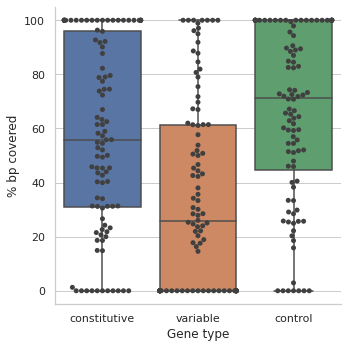

In [58]:
#Czechowski_gene_categories box plot root-shoot intersect
make_plot(cats_rootshoot,'gene_type','percentage_bases_covered','Gene type','% bp covered', f'Czechowski_{dependent_variable}', 'box')

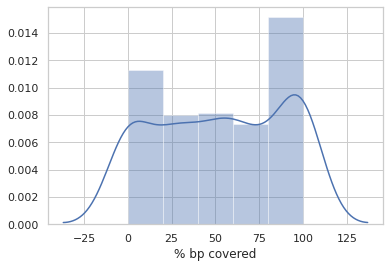

In [63]:
#all promoter distribution plot root shoot intersect
all_prom_distribution(cats_rootshoot,'percentage_bases_covered', '% bp covered', f'{dependent_variable}_allproms')

In [12]:
def test_normality(df,dependent_variable, between):
    """test normality of data categories"""
    #find gene_type categories
    pd.Categorical(df[between])
    names = df[between].unique()
    #Test normality
    #returns test statistic, p-value
    for name in names:
        print('{}: {}'.format(name, stats.shapiro(df[dependent_variable][df[between] == name])))

In [13]:
def describe_stats(df,dependent_variable, between):
    """return descriptve statistics"""
    return df.groupby([between])[dependent_variable].describe()

In [14]:
def variance(df, dependent_variable, between):
    """test variance of data categories"""
    #find gene_type categories
    pd.Categorical(df[between])
    names = df[between].unique()
    #test variance    
    return stats.levene(df[dependent_variable][df[between] == names[0]], 
               df[dependent_variable][df[between] == names[1]], 
               df[dependent_variable][df[between] == names[2]])

In [15]:
def kruskal_test(df,dependent_variable,between):
    """Do Kruskal-Wallis analysis"""
    #Kruskal-Wallis one way analysis of variance
    return kruskal(data=df, dv=dependent_variable, between=between)    

In [16]:
def dunn_posthoc_test(df,dependent_variable, between):
    """dunn_posthoc tests with bonferroni multiple correction"""
    return sp.posthoc_dunn(df, val_col=dependent_variable, group_col=between, p_adjust='bonferroni')

# root shoot intercept stats

In [17]:
df = cats_rootshoot
dependent_variable = 'percentage_bases_covered'
between_variable = 'gene_type'

In [18]:
test_normality(df,dependent_variable,between_variable)

constitutive: (0.7571035623550415, 1.4487511884597737e-11)
variable: (0.7744484543800354, 4.368349432182228e-11)
control: (0.8058207035064697, 3.7515437978363764e-10)


## not normal

In [19]:
variance(df, dependent_variable,between_variable)

LeveneResult(statistic=2.626724477646715, pvalue=0.07399456813414625)

## fail to reject null hypothesis that variances are equal



In [20]:
#descriptive stats
describe_stats(df, dependent_variable,between_variable)

,count,mean,std,min,25%,50%,75%,max
gene_type,,,,,,,,
constitutive,100.0,67.2100,39.101618,0.0,45.5625,86.625,100.0000,100.0
control,100.0,67.6875,36.250276,0.0,44.1250,81.250,100.0000,100.0
variable,100.0,38.2500,41.407695,0.0,0.0000,20.000,79.0625,100.0


In [21]:
kruskal_test(df, dependent_variable,between_variable)

,Source,ddof1,H,p-unc
Kruskal,gene_type,2,32.800812,7.540396e-08


## significant difference

In [22]:
dunn_posthoc_test(df, dependent_variable,between_variable)

,constitutive,control,variable
constitutive,-1.000000,1.000000,0.000002
control,1.000000,-1.000000,0.000002
variable,0.000002,0.000002,-1.000000


## Constitutive significantly higher than variable
## Control significantly higher than variable

# Root open chromatin stats

In [23]:
df = cats_root
dependent_variable = 'percentage_bases_covered'
between_variable = 'gene_type'

In [24]:
test_normality(df,dependent_variable,between_variable)

constitutive: (0.6810014247894287, 1.9889783721936671e-13)
variable: (0.7862942218780518, 9.596776151532538e-11)
control: (0.7227646112442017, 1.8919349593915502e-12)


In [25]:
variance(df, dependent_variable,between_variable)

LeveneResult(statistic=6.420399197575066, pvalue=0.00186316007092009)

In [26]:
#descriptive stats
describe_stats(df, dependent_variable,between_variable)

,count,mean,std,min,25%,50%,75%,max
gene_type,,,,,,,,
constitutive,100.0,72.6425,39.201343,0.0,53.1875,99.375,100.0,100.0
control,100.0,77.8300,31.742809,0.0,66.6875,100.000,100.0,100.0
variable,100.0,56.7925,42.572251,0.0,0.0000,69.125,100.0,100.0


In [27]:
kruskal_test(df, dependent_variable,between_variable)

,Source,ddof1,H,p-unc
Kruskal,gene_type,2,14.788404,0.000615


In [28]:
dunn_posthoc_test(df, dependent_variable,between_variable)

,constitutive,control,variable
constitutive,-1.000000,1.000000,0.007673
control,1.000000,-1.000000,0.001055
variable,0.007673,0.001055,-1.000000


## constitutive and control significantly higher than variable

# Shoot open chromatin stats

In [29]:
df = cats_shoot
dependent_variable = 'percentage_bases_covered'
between_variable = 'gene_type'

In [30]:
test_normality(df,dependent_variable,between_variable)

constitutive: (0.7480150461196899, 8.299831308344885e-12)
variable: (0.7855666875839233, 9.136343070981212e-11)
control: (0.7731749415397644, 4.020624111422677e-11)


In [31]:
variance(df, dependent_variable,between_variable)

LeveneResult(statistic=4.360090620490069, pvalue=0.013605127922924332)

In [32]:
#descriptive stats
describe_stats(df, dependent_variable,between_variable)

,count,mean,std,min,25%,50%,75%,max
gene_type,,,,,,,,
constitutive,100.0,68.6150,38.740679,0.0,47.2500,89.875,100.000,100.0
control,100.0,70.6925,35.684484,0.0,52.4375,87.750,100.000,100.0
variable,100.0,40.2900,41.607408,0.0,0.0000,23.500,83.375,100.0


In [33]:
kruskal_test(df, dependent_variable,between_variable)

,Source,ddof1,H,p-unc
Kruskal,gene_type,2,31.958973,1.148675e-07


In [34]:
dunn_posthoc_test(df, dependent_variable,between_variable)

,constitutive,control,variable
constitutive,-1.000000,1.000000,0.000004
control,1.000000,-1.000000,0.000002
variable,0.000004,0.000002,-1.000000


## constitutive and control significantly higher than variable